In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import Pauli
from qiskit.quantum_info import PauliList

from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

from qiskit_algorithms import NumPyMinimumEigensolver 
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA 

from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.primitives import Estimator

from qiskit_algorithms import VQE

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

qiskit_runtime_service.__init__:INFO:2024-04-20 09:45:18,573: Default instance: quantum-explorer/group-5/project-1


In [2]:
HoppingTerms = PauliList(['XXII','YYII','IIXX','IIYY'])

In [3]:
InteractionTerms = PauliList(['ZIIZ','IZZI','ZIII','IZII','IIZI','IIIZ'])

In [4]:
t = -1.0 + 0.j # weight for the hopping terms 
U = 0.5 + 0.j # weight for coulomb interaction term 

# The hamiltonian is a linear combination of ladder operators 
FH_Hamiltonian = SparsePauliOp.from_list([('XXII', t), ('YYII', t), ('IIXX', t), ('IIYY',t), 
                                  ('ZIIZ',U), ('IZZI',U),('ZIII',U),('IZII',U),('IIZI',U),('IIIZ',U)])

In [5]:
print(f"Number of qubits: {FH_Hamiltonian.num_qubits}")

Number of qubits: 4


In [6]:
# Here we compute a refernce value to compare the results later 

numpy_solver = NumPyMinimumEigensolver()
ref_result = numpy_solver.compute_minimum_eigenvalue(operator = FH_Hamiltonian)
ref_value = ref_result.eigenvalue.real
print(f"Reference value: {ref_value: .5f}")

Reference value: -4.12311


In [7]:
# Defining ansatz and optimizer 

itr_no = 100
entangler_map = [[0,1],[1,2],[2,3],[3,4]]

# MPS ansatz
FH_ansatz = TwoLocal(4, 'ry', 'cx','linear', reps=1).decompose()

# SPSA optimizer 
spsa = SPSA(maxiter=itr_no)

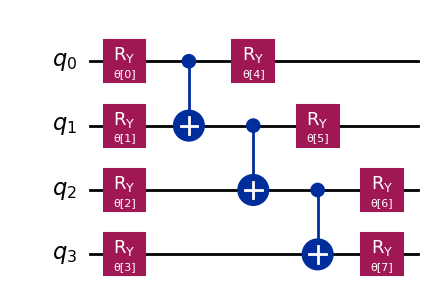

In [8]:
FH_ansatz.draw('mpl')

In [9]:
# An arbitrary couplng map to simulate the problem with a more realistic approach

coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]
device = GenericBackendV2(num_qubits=5, coupling_map=coupling_map, seed=54)

noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'measure', 'cx', 'id', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('cx', (0, 1)), ('cx', (1, 2)), ('cx', (2, 3)), ('cx', (3, 4)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [10]:
# Noise modelling with matrix product state method 

noisy_estimator = AerEstimator(
    backend_options={
        "method": "matrix_product_state",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": 54, "shots": 1024},
    transpile_options={"seed_transpiler": 54},
)

In [11]:
# Saving the intermediate results of simulation 
# to be plotted later 

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [12]:
# Specifying the ansatz and noise model to be used for Variational quantum eigensolver 
# The minimum eigenvalue is estimated on the basis of noise model and mps ansatz given 

vqe = VQE(noisy_estimator,FH_ansatz,optimizer=spsa,callback=store_intermediate_result)

In [13]:
FH_result = vqe.compute_minimum_eigenvalue(operator=FH_Hamiltonian)

In [14]:
print(f"VQE on Aer qasm simulator (with noise): {FH_result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(FH_result.eigenvalue.real - ref_value):.5f}")

# The ground state energy eigenvalue obtained may be less than the reference value 
# as we have incorporated the noise modelling and coupling map in the simulation 

VQE on Aer qasm simulator (with noise): -3.89844
Delta from reference energy value is 0.22467


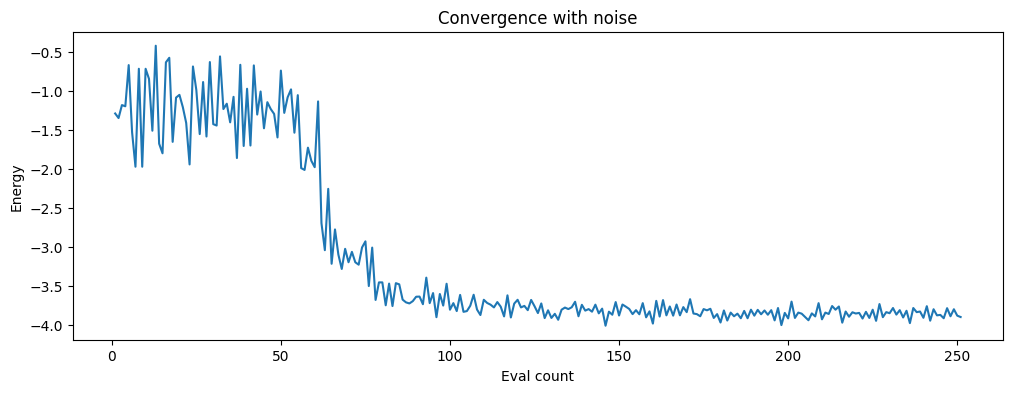

In [15]:
import pylab

# Plotting the stored intermediate eigenvalues 

if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")
    pylab.show()